In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import os
from typing import List

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.cluster import KMeans
from multiprocessing import Pool as MultiprocessingPool, cpu_count

from src.kinematics import calculate_speed_and_direction

pd.set_option("display.max_columns", None)

/Users/kniu91/Documents/projects/bdb-26/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ============================================================================
# CONFIG
# ============================================================================

class Config:
    DATA_DIR = Path("./data")
    OUTPUT_DIR = Path("./outputs")
    OUTPUT_DIR.mkdir(exist_ok=True)
    
    SEED = 42
    N_FOLDS = 5
    BATCH_SIZE = 256
    EPOCHS = 60
    PATIENCE = 30
    LEARNING_RATE = 1e-4
    
    WINDOW_SIZE = 10
    HIDDEN_DIM = 128
    MAX_FUTURE_HORIZON = 94
    
    FIELD_X_MIN, FIELD_X_MAX = 0.0, 120.0
    FIELD_Y_MIN, FIELD_Y_MAX = 0.0, 53.3
    
    K_NEIGH = 6
    RADIUS = 30.0
    TAU = 8.0
    N_ROUTE_CLUSTERS = 7
    
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(Config.SEED)



In [3]:
config = Config()
config

print("\n[1/4] Loading data...")
train_input_files = [config.DATA_DIR / f"train/input_2023_w{w:02d}.csv" for w in range(1, 19)]
train_output_files = [config.DATA_DIR / f"train/output_2023_w{w:02d}.csv" for w in range(1, 19)]
train_input = pd.concat([pd.read_csv(f) for f in train_input_files if f.exists()])
train_output = pd.concat([pd.read_csv(f) for f in train_output_files if f.exists()])
supplementary_data = pd.read_csv(config.DATA_DIR / "supplementary_data.csv")

print(f"✓ Train input: {train_input.shape}, Train output: {train_output.shape}")
print(f"✓ Train output: {train_output.shape}, unique plays: {train_output[['game_id','play_id']].drop_duplicates().shape[0]}")
print(f"✓ Supplementary data: {supplementary_data.shape}")



[1/4] Loading data...
✓ Train input: (4880579, 23), Train output: (562936, 6)
✓ Train output: (562936, 6), unique plays: 14108
✓ Supplementary data: (18009, 41)


/var/folders/_m/rvnpg_cs6xzcz0vlml0lzkbm0000gp/T/ipykernel_89941/3348770461.py:9: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supplementary_data = pd.read_csv(config.DATA_DIR / "supplementary_data.csv")


In [4]:
local_submission = pd.read_csv('local_submission.csv')
local_submission.head(2)

,game_id,play_id,nfl_id,frame_id,pred_x,pred_y,actual_x,actual_y,error
0,2023090700,101,46137,1,56.221216,17.292011,56.22,17.28,0.012073
1,2023090700,101,46137,2,56.632900,16.889301,56.63,16.88,0.009743


In [5]:
player_invariants = train_input[['game_id',
 'play_id',
 'player_to_predict',
 'nfl_id',
 'play_direction',
 'absolute_yardline_number',
 'player_name',
 'player_height',
 'player_weight',
 'player_birth_date',
 'player_position',
 'player_side',
 'player_role',
 'num_frames_output',
 'ball_land_x',
 'ball_land_y']].drop_duplicates()

In [48]:
import pandas as pd
# from nfl import visuals
from nfl_custom import visuals
import matplotlib.pyplot as plt
import importlib
importlib.reload(visuals)

print(local_submission.shape)
tracking_data = local_submission.merge(player_invariants, on=['game_id', 'play_id', 'nfl_id'], how = 'left', indicator=True).query('_merge == "both"')
print(tracking_data.shape)
tracking_data.drop(columns=['_merge'], inplace=True)

tracking_data['x'] = tracking_data['actual_x']
tracking_data['y'] = tracking_data['actual_y']

# tracking_data.loc[(tracking_data['nfl_id'] == 52566), 'x'] = tracking_data.loc[(tracking_data['nfl_id'] == 52566), 'pred_x']
# tracking_data.loc[(tracking_data['nfl_id'] == 52566), 'y'] = tracking_data.loc[(tracking_data['nfl_id'] == 52566), 'pred_y']

    # raise ValueError("Tracking data for the specified game_id and play_id not found.")
# 2023100108	2805
# 2023112603	1618	
# 2023121801	3916
# 2023102908	524	
# 2023100811	1168
# 2023112603	1618
# 2023091007	2208
# 2023112606	2349
# 2023112606	2349
# 2023121701	3755
# 2023111906	2507	
# 2023102904	1747
# 2023112609	1852
# 2023091011	1686
context_data = supplementary_data
# 2023100113	1796
# 2023100108	2805
play = visuals.Play(tracking_data, 2023100108, 2805, context_data, flip_field=False)

(562936, 9)
(562936, 23)


In [50]:
play.animate(show_trajectories=True, 
             predraw_trajectories = True, 
             traj_alpha=1, 
             traj_linewidth=1.2, 
            #  highlight_player_id=46186,
             speed = 100,
             filename = 'reed_blankenship.gif',
             save = True,
             fps = 10,
             show_actual = True,
            show_predicted = True
             )

Animation saved to reed_blankenship.gif


In [ ]:
ename = 'bryce_hall_falls_down_w_real_animation.gif',
                               highlight_player_id = 52566
                               
                               )
relay_animation

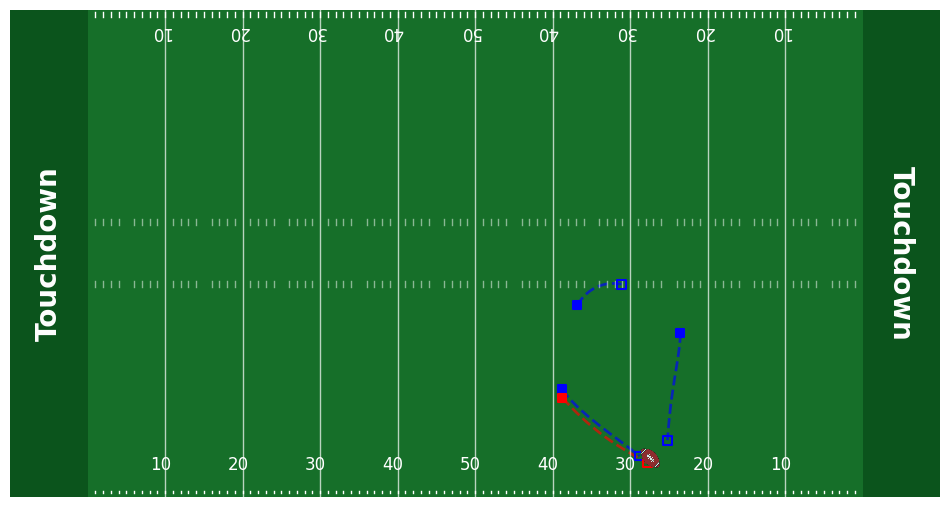

In [35]:
fig, ax = play.plot_trajectories(
  # show_actual = True,
  show_actual = False,
  show_predicted = True,
  # highlight_player_id = 46186
  )

plt.show()

KeyError: 'player_side'

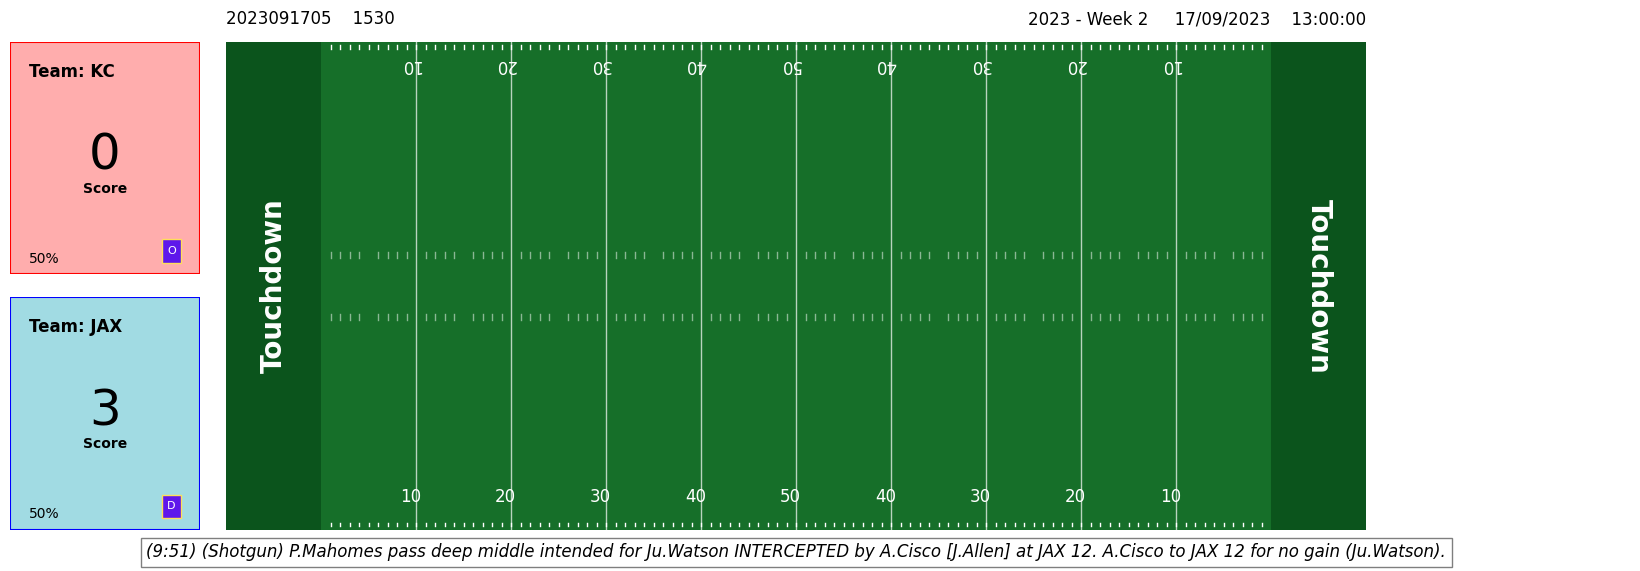

In [20]:
play

fig, ax = play.plot_snap(frameId=10, relay=True)
plt.show()

In [15]:
player_impacts = pd.read_csv('./outputs/defender_impact_lgb.csv')
player_impacts.head(2)

,game_id,play_id,nfl_id,player_role,baseline_prob,real_prob,delta,fold
0,2023091000,185,46123,Defensive Coverage,0.831678,0.831678,0.0,1
1,2023091000,185,48027,Defensive Coverage,0.831678,0.831678,0.0,1


In [9]:
catch_probabilities = pd.read_csv('./outputs/catch_probabilities_lgb.csv')
catch_probabilities = catch_probabilities.rename(columns={
  'pred_catch_prob_by_proj_traj': 'baseline_prob',
  'pred_catch_prob_by_real_traj': 'real_prob',
})
catch_probabilities['delta'] = catch_probabilities['real_prob'] - catch_probabilities['baseline_prob']

catch_probabilities
print(catch_probabilities.shape)
catch_probabilities = catch_probabilities.merge(supplementary_data[['game_id','play_id','pass_result', 'yards_gained', 'season','week','home_team_abbr','visitor_team_abbr','play_description', 'quarter','game_clock']],
        on=['game_id','play_id'], how='left')
print(catch_probabilities.shape)
catch_probabilities = catch_probabilities.merge(train_input[['game_id','play_id']].drop_duplicates(),
        on=['game_id','play_id'], how='left')
print(catch_probabilities.shape)
catch_probabilities.sort_values('delta', ascending = False).head(3)

(13132, 5)
(13132, 14)
(13132, 14)


,game_id,play_id,baseline_prob,real_prob,delta,pass_result,yards_gained,season,week,home_team_abbr,visitor_team_abbr,play_description,quarter,game_clock
10937,2023100807,2356,0.057876,0.853926,0.796051,C,63,2023,5,ARI,CIN,(13:47) (Shotgun) J.Burrow pass deep right to ...,3,13:47
7173,2023120307,2246,0.126524,0.860678,0.734154,C,39,2023,13,HOU,DEN,(11:44) (Shotgun) C.Stroud pass deep middle to...,3,11:44
10107,2023122410,551,0.069271,0.795257,0.725986,C,50,2023,16,MIA,DAL,(6:32) (Shotgun) T.Tagovailoa pass deep right ...,1,06:32


In [13]:
player_impacts = pd.read_csv('./outputs/defender_impact_lgb.csv')
print(player_impacts.shape)
player_impacts = player_impacts.merge(supplementary_data[['game_id','play_id','pass_result', 'yards_gained', 'season','week','home_team_abbr','visitor_team_abbr','play_description', 'quarter','game_clock']],
        on=['game_id','play_id'], how='left')
print(player_impacts.shape)
# player_impacts = player_impacts.merge(train_input,
#         on=['game_id','play_id','nfl_id','frame_id'], how='left')
# print(player_impacts.shape)
# player_impacts = player_impacts.merge(supplementary_data,
#         on=['game_id','play_id'], how='left')
# print(player_impacts.shape)

# # player_impacts = player_impacts.merge(defender_type[['game_id','play_id','nfl_id','defender_type']],
# #                                       on = ['game_id','play_id','nfl_id'],
# #                                       how = 'left')
# print(player_impacts.shape)

# # player_impacts = player_impacts.merge(potential_contact[['game_id','play_id','nfl_id', 'potential_contact']],
# #                                       on = ['game_id','play_id','nfl_id'],
# #                                       how = 'left')
# print(player_impacts.shape)

# print(player_impacts.shape)

# player_impacts.sort_values('delta', ascending = False).head(3)

(44032, 8)
(44032, 17)


In [ ]:
catch_probabilities[
  (catch_probabilities['game_id'] == 2023091705)&
  (catch_probabilities['play_id'] == 1530)
